# Mask Object Detection Data Cleaning and Preparation

This notebook will clean and possibly remove a range of images from our object detection dataset, based on the extracted bounding box region sizes.

---

- **Author:** Ben Fraser, https://github.com/BenjaminFraser
- **Date:** 10 August 2022

## 1. Imports and data directories setup

In [1]:
import itertools
import json
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import pandas as pd
import PIL.Image as Image
import random
import urllib
import seaborn as sns
import skimage.color
import skimage.io
import shutil
import xml.etree.ElementTree as ET

from datetime import datetime
from matplotlib import rc
from matplotlib.lines import Line2D
from matplotlib.colors import rgb_to_hsv
from tqdm import tqdm

%matplotlib inline
sns.set_style("whitegrid")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

Within this notebook we'll extract all the reliable (decent sized, clear annotations) and move them into a new directory, which will serve as the basis of a new dataset to extract pose features from using AlphaPose.

In [2]:
# get project path and set data directory for notebook
PROJECT_PATH = os.sep.join(os.getcwd().split(os.sep)[:-1])
DATA_DIR = os.path.join(PROJECT_PATH, 'data/')

# set path to dataset selected within data dir
DATASET_NAME = "custom_mask_dataset"
DATASET_DIR = os.path.join(DATA_DIR, DATASET_NAME)

# set path to desired dataset and annotations for this notebook
IMAGE_DIR = os.path.join(DATASET_DIR, 'Images')
ANNOTATIONS_DIR = os.path.join(DATASET_DIR, 'Annotations')
IMAGE_EXT = '.jpg'
ANNOT_FILETYPE = '.xml'

In [3]:
image_files = [x for x in os.listdir(IMAGE_DIR) if x.endswith(IMAGE_EXT)]
annotation_files = [x for x in os.listdir(ANNOTATIONS_DIR) if x.endswith('.xml')]

print(f"Number of image files: {len(image_files)}")
print(f"Number of annotation files: {len(annotation_files)}")

Number of image files: 5311
Number of annotation files: 5311


As shown, we have over 5300 images and associated annotations for the entire dataset. Each image may have multiple (some with a large number) mask annotations. This gives us a nice and large dataset to build our face-mask object detector.

## 2. Dataset exploration and Cleaning

Lets define some helper functions to analyse our input data and associated annotations.

In [4]:
def read_xml_annotations(xml_filename: str, height_width_scaling=None):
    """ Parse our xml object detection bounding box annotations from
        file and return all classes with associated co-ords in
        [x_min, y_min, x_max, y_max] format. """

    tree = ET.parse(xml_filename)
    root = tree.getroot()
    
    # arrays to store class label and associated bbox coords
    classes = []
    bounding_boxes = []
    
    # iterate through all objects in file, gather class & bbox coords
    for boxes in root.iter('object'):

        filename = root.find('filename').text
        
        x_min, y_min, x_max, y_max = None, None, None, None

        # get class name and associated bbox coords
        class_name = boxes.find("name").text
        x_min = int(float(boxes.find("bndbox/xmin").text))
        y_min = int(float(boxes.find("bndbox/ymin").text))
        x_max = int(float(boxes.find("bndbox/xmax").text))
        y_max = int(float(boxes.find("bndbox/ymax").text))
        
        # add current class & bbox to our collection for this image
        bounding_boxes.append([x_min, y_min, x_max, y_max])
        classes.append(class_name)

    return filename, classes, bounding_boxes

def load_image(path, convert_rgba=True):
    """Load the specified image and return a [H,W,3] Numpy array."""
    # Load image
    image = skimage.io.imread(path)
    # If grayscale. Convert to RGB for consistency.
    if image.ndim != 3:
        image = skimage.color.gray2rgb(image)
        
    # if rgba - convert to rgb for consistency
    if convert_rgba and image.shape[2] == 4:
        image = skimage.color.rgba2rgb(image)
    return image

def make_labels_df_from_dir(img_dir, labels_dir, get_label_func, 
                            img_ext='.png', labels_ext='xml'):
    """ Combines all yolo formatted labels from a selected directory
        and places them into a dataframe. Must provide a get_label_func to
        precisely extract the labels from the annotations file """
    
    records = []
    labels_files = [x for x in os.listdir(labels_dir) 
                    if x.endswith(labels_ext) and x != 'classes.txt']
    
    # get annotation labels for all our images
    for label_file in labels_files:
        img_labels = get_label_func(label_file, 
                                    img_dir,
                                    labels_dir,
                                    img_ext)
        
        records.extend(img_labels)
        
    # create a final dataframe of results
    results_df = pd.DataFrame(records)   
    
    return results_df


def get_labels_from_xml_file(labels_filename, img_dir=IMAGE_DIR, 
                             labels_dir=ANNOTATIONS_DIR, img_ext='.png'):
    """ Combines bounding box labels for given image into a dataframe """ 

    base_name = labels_filename[:-4]
    img_path = os.path.join(img_dir, f"{base_name}{img_ext}")
    labels_path = os.path.join(labels_dir, labels_filename)

    # extract class names and bbox coords from current image
    _, class_labels, bbox_coords = read_xml_annotations(labels_path)

    # load image and get height and width
    try:
        img = load_image(img_path)
        img_height, img_width, _ = img.shape
    except FileNotFoundError:
        img_height, img_width = "No image found", "No image found"

    # create array to store labels
    records = []

    # gather all bounding boxes for given image
    for idx, class_name in enumerate(class_labels):
        
        # get bbox coords for current class_name object
        x_min, y_min, x_max, y_max = bbox_coords[idx]
        
        # form a dict with all our desired quantities
        record = {'filename' : f"{base_name}{img_ext}", 
                  'img_width' : img_width,
                  'img_height' : img_height, 
                  'object' : class_name,
                  'x_min' : x_min, 'y_min' : y_min, 
                  'x_max' : x_max, 'y_max' : y_max}
        records.append(record)
    return records

Let's also develop a pandas dataframe containing all of our annotation labels across all images, which will make it much easier to analyse our dataset as a whole:

In [5]:
labels_df = make_labels_df_from_dir(img_dir=IMAGE_DIR, 
                                    labels_dir=ANNOTATIONS_DIR, 
                                    get_label_func=get_labels_from_xml_file,
                                    img_ext=IMAGE_EXT)

In [6]:
labels_df['object'].value_counts()

mask            9161
with-mask       4584
without-mask    3344
nomask          3015
unsure          1309
with_mask        730
without_mask     416
0                150
1                108
2                 59
Name: object, dtype: int64

There are a huge number of unsure annotations in the dataset. There really is no point leaving these in the data we're curating, since these will generally be of very low quality, whereby its impossible to tell whether the person is wearing a mask or not. It's also likely many of these unsure classes are very small annotations, which would be of little value anyway.

As shown above, we also have mixed methods used for annotating the mask labels. This is due to our total data consisting of multiple object detection datasets. The label types are all equivalent, they just need to be made consistent, as below:

In [7]:
# make these class outputs consistent with our previous ones
correction_dict = {'mask' : 'with_mask',
                   'nomask' : 'without_mask',
                   'NM' : 'without_mask', 
                   'MW' : 'with_mask',
                   'with-mask' : 'with_mask',
                   'without-mask' : 'without_mask',
                   '0' : 'with_mask',
                   '1' : 'without_mask',
                   '2' : 'unsure'}

labels_df['object'] = labels_df['object'].replace(correction_dict)

In [8]:
labels_df['object'].value_counts()

with_mask       14625
without_mask     6883
unsure           1368
Name: object, dtype: int64

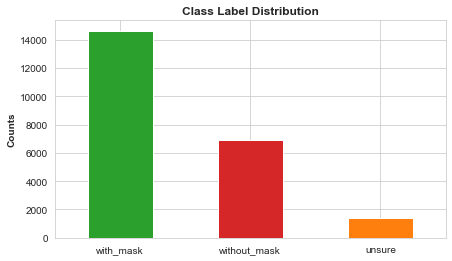

In [9]:
labels_df['object'].value_counts().plot.bar(
    color=['tab:green', 'tab:red', 'tab:orange'],
    figsize=(7,4))
plt.ylabel("Counts", weight="bold")
plt.title("Class Label Distribution", weight="bold")
plt.xticks(rotation=0)
plt.show()

For now, let's drop our unsure annotations, since they are difficult to integrate effectively into our model. We would rather use solid positive or negative training examples to develop our model, rather than ambiguous and potentially harmful unsure examples (since they are all actually either masked / unmasked).

In [10]:
# get unsure indices and drop from our data
unsure_idxs = labels_df.loc[labels_df['object'] == 'unsure'].index
labels_df = labels_df.drop(unsure_idxs)

# reindex our dataframe after droping
labels_df = labels_df.reset_index(drop=True)

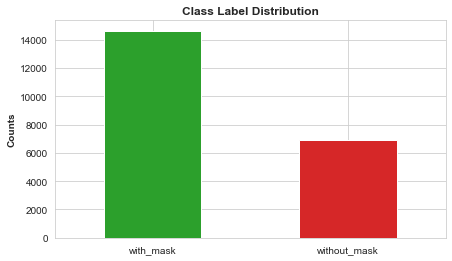

In [11]:
labels_df['object'].value_counts().plot.bar(
    color=['tab:green', 'tab:red'],
    figsize=(7,4))
plt.ylabel("Counts", weight="bold")
plt.title("Class Label Distribution", weight="bold")
plt.xticks(rotation=0)
plt.show()

We also have a range of samples that have zero annotations, we'll get rid of these too:

In [12]:
zero_annots = ((labels_df['x_min'] == 0) & (labels_df['x_max'] == 0) & 
               (labels_df['y_min'] == 0) & (labels_df['y_max'] == 0))

labels_df.loc[zero_annots]

,filename,img_width,img_height,object,x_min,y_min,x_max,y_max
5548,MOXA_1029.jpg,920,606,without_mask,0,0,0,0
5549,MOXA_1029.jpg,920,606,without_mask,0,0,0,0
5550,MOXA_1029.jpg,920,606,without_mask,0,0,0,0
5551,MOXA_1029.jpg,920,606,without_mask,0,0,0,0
5552,MOXA_1029.jpg,920,606,without_mask,0,0,0,0
5553,MOXA_1029.jpg,920,606,without_mask,0,0,0,0
5554,MOXA_1029.jpg,920,606,without_mask,0,0,0,0
5555,MOXA_1029.jpg,920,606,with_mask,0,0,0,0
5556,MOXA_1029.jpg,920,606,with_mask,0,0,0,0


In [13]:
# gather erroneous indices for image and drop
idx_to_drop = labels_df.loc[zero_annots].index

labels_df = labels_df.drop(idx_to_drop)

# reindex our dataframe after droping
labels_df = labels_df.reset_index(drop=True)

Lets analyse the distribution of bounding box annotation sizes, and remove outliers or impractical images / annotations:

In [14]:
large_values = ((labels_df['x_min'] > 5000) | (labels_df['x_max'] > 5000) | 
                (labels_df['y_min'] > 5000) | (labels_df['y_max'] > 5000))

labels_df.loc[large_values]

,filename,img_width,img_height,object,x_min,y_min,x_max,y_max
118,St_Louis St_Louis143.jpg,1920,1080,without_mask,646080,369900,2099520,1215540
390,Times_Square times_square_82.jpg,1920,1080,with_mask,1225920,503280,3754560,1559520
409,Times_Square times_square_96.jpg,1920,1080,with_mask,519360,536760,1642560,1664280
859,1593655441.68523.jpg,1920,1080,without_mask,320640,490860,1054080,1537380
860,1593655441.68523.jpg,1920,1080,without_mask,863040,522720,2696640,1637280
...,...,...,...,...,...,...,...,...
20296,1.jpg,1280,720,with_mask,715520,108000,2220800,367200
20297,1.jpg,1280,720,without_mask,654080,97200,2013440,326160
20298,1.jpg,1280,720,with_mask,652160,97200,2012800,326160
20299,1.jpg,1280,720,with_mask,555520,108720,1715200,362160


Some of these are evidently erroneous, since the annotation co-ordinates are much too large to belong to the image. We'll simply remove these.

In [15]:
# gather erroneous indices for image and drop
idx_to_drop = labels_df.loc[large_values].index
labels_df = labels_df.drop(idx_to_drop)

# reindex our dataframe after droping
labels_df = labels_df.reset_index(drop=True)

Let's now work out the bounding box heights and widths:

In [16]:
labels_df['delta_x'] = labels_df['x_max'] - labels_df['x_min']
labels_df['delta_y'] = labels_df['y_max'] - labels_df['y_min']

print(f"Min Annotation Width = {labels_df['delta_x'].min()}")
print(f"Min Annotation Height = {labels_df['delta_y'].min()}")

print(f"Max Annotation Width = {labels_df['delta_x'].max()}")
print(f"Max Annotation Height = {labels_df['delta_y'].max()}")

print(f"Mean Annotation Width = {labels_df['delta_x'].mean()}")
print(f"Mean Annotation Height = {labels_df['delta_y'].mean()}")

Min Annotation Width = 2
Min Annotation Height = 1
Max Annotation Width = 1828
Max Annotation Height = 1783
Mean Annotation Width = 44.972619438323406
Mean Annotation Height = 56.89183740447278


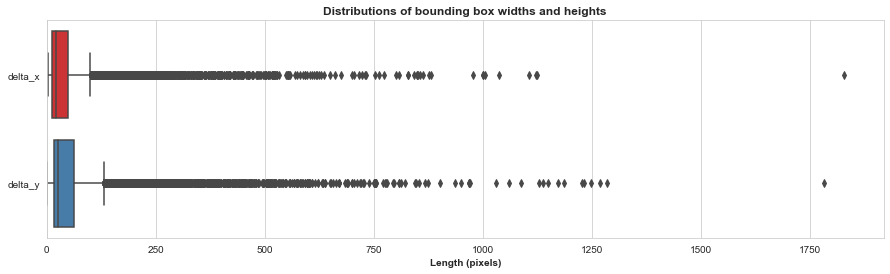

In [17]:
plt.figure(figsize=(15,4))
sns.boxplot(data=labels_df.loc[:, ['delta_x', 'delta_y']], orient="h", palette="Set1")
plt.xlim(0)
plt.xlabel("Length (pixels)", weight="bold")
plt.title("Distributions of bounding box widths and heights", weight="bold")
plt.show()

Some of the height and width annotations only span 1/2 pixels, as shown above. It's better to just remove these entirely, since they won't generally be any use to our model.

We'll remove all bounding boxes with either a height or width below a given amount (say, 10 pixels). This will ensure that we are only left with reasonable size boxes:

In [18]:
# get bounding boxes below a given height or width
low_thresh = 20
high_thresh = 800

small_bboxs = ((labels_df['delta_x'] <= low_thresh) | 
               (labels_df['delta_y'] <= low_thresh))
small_bbox_idx = labels_df.loc[small_bboxs].index

large_bboxs = ((labels_df['delta_x'] >= high_thresh) | 
               (labels_df['delta_y'] >= high_thresh))
large_bbox_idx = labels_df.loc[large_bboxs].index

# drop these from our dataset
labels_df = labels_df.drop(small_bbox_idx)
labels_df = labels_df.drop(large_bbox_idx)

# reindex our dataframe after droping
labels_df = labels_df.reset_index(drop=True)

Lets compare this again using a boxplot for the width and heights, to ensure our changes have been reflected in the dataset:

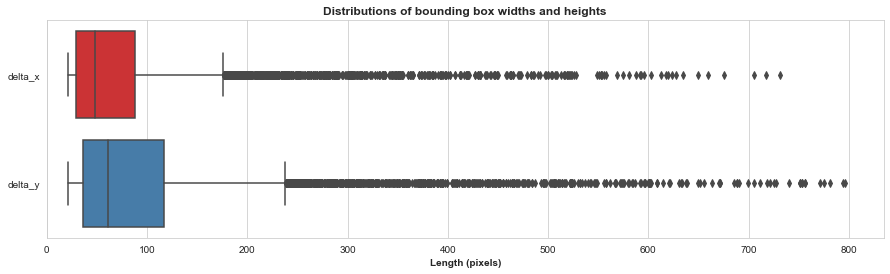

In [19]:
plt.figure(figsize=(15,4))
sns.boxplot(data=labels_df.loc[:, ['delta_x', 'delta_y']], orient="h", palette="Set1")
plt.xlim(0)
plt.xlabel("Length (pixels)", weight="bold")
plt.title("Distributions of bounding box widths and heights", weight="bold")
plt.show()

This looks much better, with less outliers than we had before.

In [20]:
# color map dictionary for different classes
color_map = {'with_mask' : [0.0, 255.0, 0.0],
             'without_mask' : [255.0, 0.0, 0.0]}

In [21]:
def draw_box(img, img_labels, color_map, t=2):
    """Draw 3-pixel width bounding boxes on the given image array.
    color: list of 3 int values for RGB. 
    t: Thickness of bounding box in pixels
    """
    # make a copy of the image to annotate
    annot_img = img.copy()

    # get x/y co-ords for all bboxes
    boxes = img_labels[['x_min', 'y_min', 'x_max', 'y_max']].values
    
    # get object labels for each bounding box
    object_labels = img_labels['object'].values
    
    # find number of boxes for given image
    num_boxes = boxes.shape[0]

    # convert bboxes to integers
    bboxes = boxes.astype(int)

    # iterate through all boxes and plot
    for i in range(num_boxes):
        # get co-ords for current bbox
        x_min, y_min, x_max, y_max = bboxes[i]
        
        # get associated color, subject to object type
        color = color_map[object_labels[i]]

        # plot bbox on image with desired thickness
        annot_img[y_min:y_min + t, x_min:x_max] = color
        annot_img[y_max:y_max + t, x_min:x_max] = color
        annot_img[y_min:y_max, x_min:x_min + t] = color
        annot_img[y_min:y_max, x_max:x_max + t] = color

    return annot_img, num_boxes


def plot_annotations(img_name, labels_df, data_dir=IMAGE_DIR, 
                     color_map=color_map, figsize=(12,10), legend=False):
    """ Helper function for plotting image & annotations """ 
    img = load_image(f"{data_dir}/{img_name}")
    img, num_boxes = draw_box(img, 
                        labels_df.loc[labels_df['filename'] == img_name],
                        color_map)
    
    plt.figure(figsize=figsize)
    plt.title(img_name, size=10)
    plt.imshow(img)
    plt.axis('off')
    
    # if legend chosen, annotate what class is which color
    if legend:
        # map color map colors to matplotlib style colors
        mpl_color_map = dict()
        for object_name in color_map.keys():
            mpl_color_map[object_name] = tuple([i/255 for i 
                                            in color_map[object_name]])
    
        # get object names and create legend lines for each class type
        object_ids = list(color_map.keys())
    
        legend_lines = [Line2D([0],[0], color=mpl_color_map[object_ids[i]], lw=2) 
                        for i in range(len(object_ids))]
        plt.legend(legend_lines, object_ids, loc='best')
        
    plt.show()
    print(f"\nNumber of annotations: {num_boxes}\n")
    return

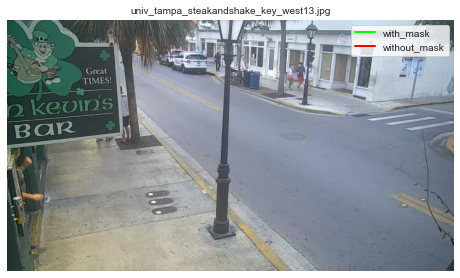


Number of annotations: 0



In [22]:
plot_annotations('univ_tampa_steakandshake_key_west13.jpg', 
                 labels_df, figsize=(8,6), legend=True)

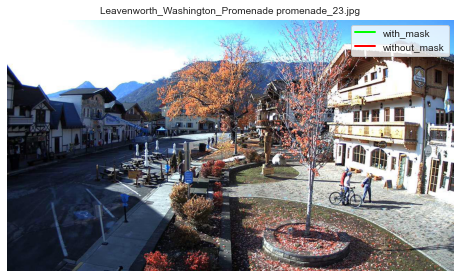


Number of annotations: 0



In [23]:
plot_annotations('Leavenworth_Washington_Promenade promenade_23.jpg', 
                 labels_df, figsize=(8,6), legend=True)

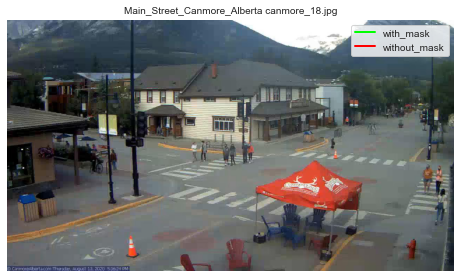


Number of annotations: 0



In [24]:
plot_annotations('Main_Street_Canmore_Alberta canmore_18.jpg', 
                 labels_df, figsize=(8,6), legend=True)

These really complex scenes with small annotations just aren't useful by default. 

We can either tile images into smaller individual images, which would let our object detector better learn the features. Alternatively, we can just remove them, which we'll do for now to save the efforts and complexities of tiling.

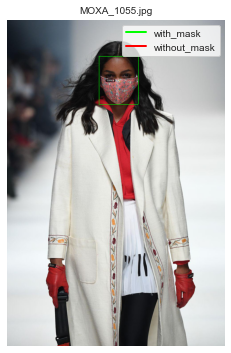


Number of annotations: 1



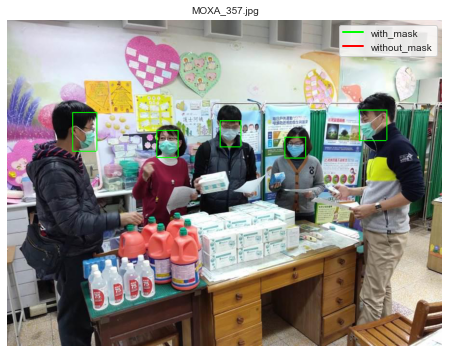


Number of annotations: 5



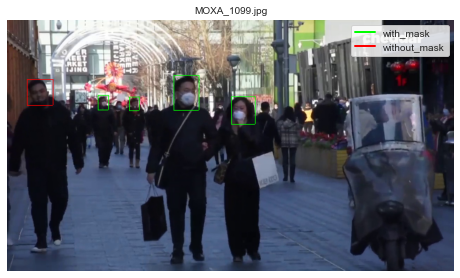


Number of annotations: 5



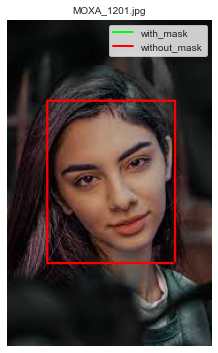


Number of annotations: 1



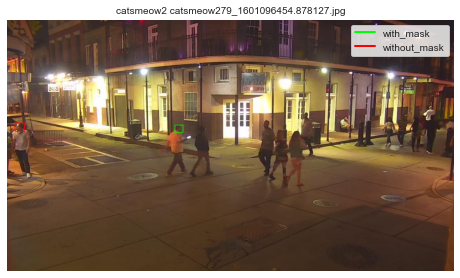


Number of annotations: 2



In [25]:
random_images = np.random.choice(labels_df['filename'].unique(), size=5)
for random_img in random_images:
    plot_annotations(random_img, labels_df, figsize=(8,6), legend=True)

These images look a lot more suitable for curating our dataset. We'll save the unique image names for this dataset and form a dataset consisting only of these images:

## 3. Saving of our cleaned dataset

In [26]:
labels_df['object'].value_counts()

with_mask       7730
without_mask    3054
Name: object, dtype: int64

In [27]:
len(labels_df['filename'].unique())

3650

We have a total of 3650 images, of which we have circa 10k mask annotations. Hopefully, through extracting pose features for all of these images, we'll be able to get reasonable extracted boxes with heads, so that we can perform image classification (rather than object detection).

In [28]:
# get list of images and annotations to move
original_images = labels_df['filename'].unique()
original_annots = [f"{x[:-4]}.xml" for x in original_images]

print(f"Number of images: {len(original_images)}")
print(f"Number of annotations: {len(original_annots)}")

Number of images: 3650
Number of annotations: 3650


Let's move these images and associated labels into new directories with the final dataset:

In [29]:
# define new directory name, and create dirs (if they dont exist)
NEW_DATASET_DIR = os.path.join(DATA_DIR, f"{DATASET_NAME}_cleaned")
NEW_IMG_DIR = os.path.join(NEW_DATASET_DIR, 'Images')
NEW_ANNOT_DIR = os.path.join(NEW_DATASET_DIR, 'Annotations')
os.makedirs(NEW_IMG_DIR, exist_ok=True)
os.makedirs(NEW_ANNOT_DIR, exist_ok=True)

In [30]:
# copy all of the files and annotations to new dirs
for i, img_name in tqdm(enumerate(original_images)):
    
    # get original filepaths
    img_input_path = os.path.join(IMAGE_DIR, original_images[i])
    annot_input_path = os.path.join(ANNOTATIONS_DIR, original_annots[i])
    
    # get new filepaths
    img_dest_path = os.path.join(NEW_IMG_DIR, original_images[i])
    annot_dest_path = os.path.join(NEW_ANNOT_DIR, original_annots[i])
    
    # move files
    shutil.copy(img_input_path, img_dest_path)
    shutil.copy(annot_input_path, annot_dest_path)

3650it [00:03, 949.89it/s] 


In [31]:
len(os.listdir(NEW_IMG_DIR)), len(os.listdir(NEW_ANNOT_DIR))

(3650, 3650)

Lets also save the annotations in a more convenient .csv format:

In [32]:
# save our annotations within new dataset directory
now = datetime.now()
current_date = now.strftime("%Y%m%d")
labels_df.to_csv(os.path.join(NEW_DATASET_DIR, 
                              f"{current_date}-cleaned_mask_dataset_annotations.csv"), 
                 index=False)

Good, we now have a cleaned and suitable dataset for building a robust human face-mask object detector. Given the wide range of scenes used, from extremely simple to complex far-distanced scenes, this should help build a reliable mask detector that is effective on video surveillance scenes - typically the kind of data inputs we are interest in for this application.